In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from xgboost import plot_tree

# Other
import warnings
warnings.filterwarnings("ignore")


# Allow us to use tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/data/

import pandas as pd

original = pd.read_csv('dataset.csv')
df=original.copy()

Mounted at /content/drive
/content/drive/MyDrive/data


In [ ]:
df.head()

,id,spkid,full_name,pdes,name,prefix,neo,pha,H,diameter,...,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,rms
0,a0000001,2000001,1 Ceres,1,Ceres,NaN,N,N,3.40,939.400,...,4.608900e-09,6.168800e-08,6.624800e-08,7.820700e-09,1.111300e-11,1.196500e-12,3.782900e-08,9.415900e-09,MBA,0.43301
1,a0000002,2000002,2 Pallas,2,Pallas,NaN,N,N,4.20,545.000,...,3.469400e-06,6.272400e-06,9.128200e-06,8.859100e-06,4.961300e-09,4.653600e-10,4.078700e-05,3.680700e-06,MBA,0.35936
2,a0000003,2000003,3 Juno,3,Juno,NaN,N,N,5.33,246.596,...,3.223100e-06,1.664600e-05,1.772100e-05,8.110400e-06,4.363900e-09,4.413400e-10,3.528800e-05,3.107200e-06,MBA,0.33848
3,a0000004,2000004,4 Vesta,4,Vesta,NaN,N,N,3.00,525.400,...,2.170600e-07,3.880800e-07,1.789300e-07,1.206800e-06,1.648600e-09,2.612500e-10,4.103700e-06,1.274900e-06,MBA,0.39980
4,a0000005,2000005,5 Astraea,5,Astraea,NaN,N,N,6.90,106.699,...,2.740800e-06,2.894900e-05,2.984200e-05,8.303800e-06,4.729000e-09,5.522700e-10,3.474300e-05,3.490500e-06,MBA,0.52191


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958524 entries, 0 to 958523
Data columns (total 45 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              958524 non-null  object 
 1   spkid           958524 non-null  int64  
 2   full_name       958524 non-null  object 
 3   pdes            958524 non-null  object 
 4   name            22064 non-null   object 
 5   prefix          18 non-null      object 
 6   neo             958520 non-null  object 
 7   pha             938603 non-null  object 
 8   H               952261 non-null  float64
 9   diameter        136209 non-null  float64
 10  albedo          135103 non-null  float64
 11  diameter_sigma  136081 non-null  float64
 12  orbit_id        958524 non-null  object 
 13  epoch           958524 non-null  float64
 14  epoch_mjd       958524 non-null  int64  
 15  epoch_cal       958524 non-null  float64
 16  equinox         958524 non-null  object 
 17  e         

## Data Preprocessing

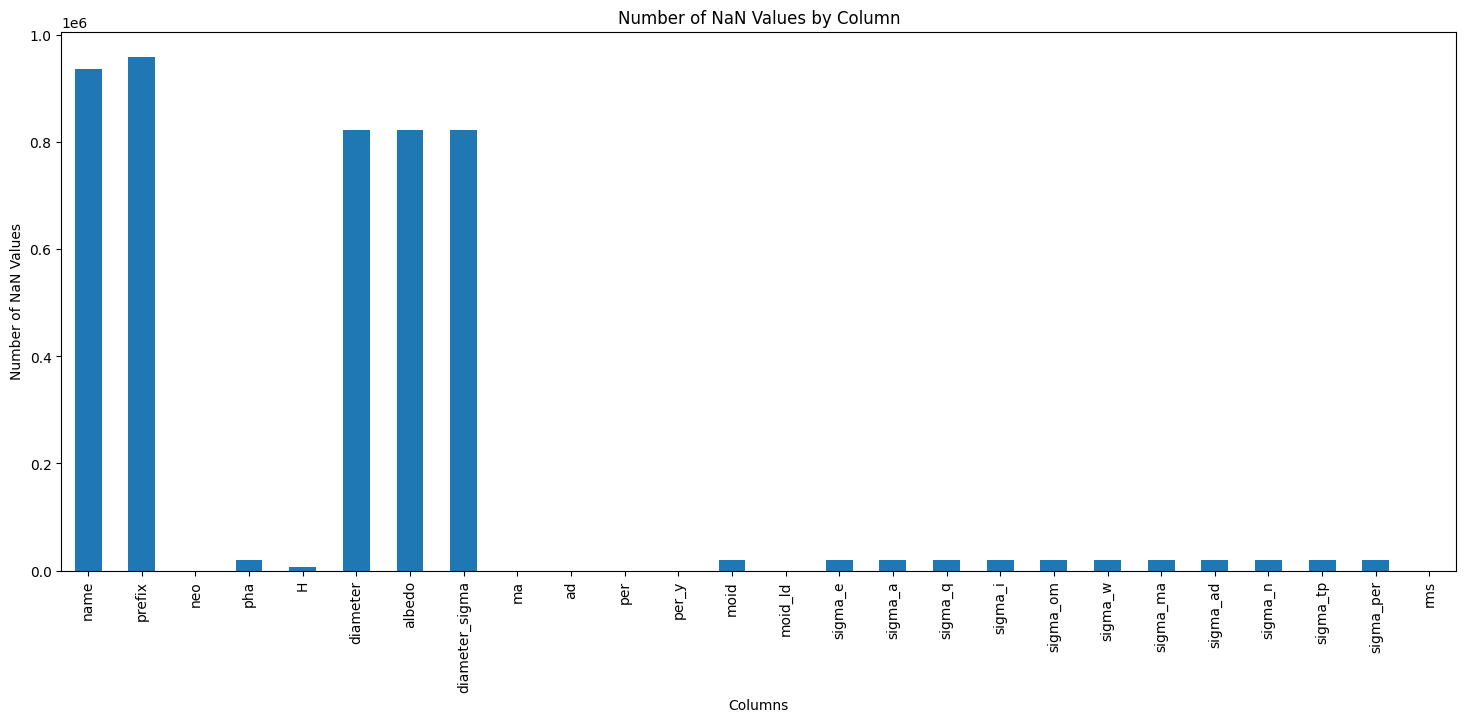

In [ ]:
nan_counts = df.isnull().sum()

# filter the nan_counts Series to include only columns with non-zero NaN counts
nan_counts_filtered = nan_counts[nan_counts > 0]

# create a bar chart of the filtered NaN counts
plt.figure(figsize=(18, 7))
nan_counts_filtered.plot(kind='bar')
plt.title('Number of NaN Values by Column')
plt.xlabel('Columns')
plt.ylabel('Number of NaN Values')
plt.show()


In [ ]:
# Columns with missing values in Perentage
missing_cols = df.isna().mean() * 100
missing_cols = missing_cols[missing_cols > 0]
print("Percentage of missing values:\n", missing_cols)

Percentage of missing values:
 name              97.698128
prefix            99.998122
neo                0.000417
pha                2.078300
H                  0.653400
diameter          85.789714
albedo            85.905100
diameter_sigma    85.803068
ma                 0.000104
ad                 0.000417
per                0.000417
per_y              0.000104
moid               2.078300
moid_ld            0.013250
sigma_e            2.078404
sigma_a            2.078404
sigma_q            2.078404
sigma_i            2.078404
sigma_om           2.078404
sigma_w            2.078404
sigma_ma           2.078404
sigma_ad           2.078821
sigma_n            2.078404
sigma_tp           2.078404
sigma_per          2.078821
rms                0.000209
dtype: float64


In [3]:
from scipy import stats


# Check for missing values in the "H" attribute
missing = df['H'].isna()

# Prepare the data for Little's MCAR test
observed = np.array([sum(~missing), sum(missing)])
expected = np.array([len(df) * (1 - np.mean(missing)), len(df) * np.mean(missing)])

# Conduct the test and calculate the p-value
chi2, p_value = stats.chisquare(observed, f_exp=expected)
print(p_value)
# Interpret the results
if p_value < 0.05:
    print("The missing data mechanism for 'H' is not MCAR.")
else:
    print("The missing data mechanism for 'H' is MCAR.")

1.0
The missing data mechanism for 'H' is MCAR.


In [4]:
# Check for missing values in the "diameter" attribute
missing = df['diameter'].isna()

# Prepare the data for Little's MCAR test
observed = np.array([sum(~missing), sum(missing)])
expected = np.array([len(df) * (1 - np.mean(missing)), len(df) * np.mean(missing)])

# Conduct the test and calculate the p-value
chi2, p_value = stats.chisquare(observed, f_exp=expected)
print(p_value)
# Interpret the results
if p_value < 0.05:
    print("The missing data mechanism for 'diameter' is not MCAR.")
else:
    print("The missing data mechanism for 'diameter' is MCAR.")

0.999999999999937
The missing data mechanism for 'diameter' is MCAR.


In [5]:
# Check for missing values in the "albedo" attribute
missing = df['albedo'].isna()

# Prepare the data for Little's MCAR test
observed = np.array([sum(~missing), sum(missing)])
expected = np.array([len(df) * (1 - np.mean(missing)), len(df) * np.mean(missing)])

# Conduct the test and calculate the p-value
chi2, p_value = stats.chisquare(observed, f_exp=expected)
print(p_value)
# Interpret the results
if p_value < 0.05:
    print("The missing data mechanism for 'albedo' is not MCAR.")
else:
    print("The missing data mechanism for 'albedo' is MCAR.")

0.9999999999999368
The missing data mechanism for 'albedo' is MCAR.


In [6]:
# Check for missing values in the "diameter_sigma" attribute
missing = df['diameter_sigma'].isna()

# Prepare the data for Little's MCAR test
observed = np.array([sum(~missing), sum(missing)])
expected = np.array([len(df) * (1 - np.mean(missing)), len(df) * np.mean(missing)])

# Conduct the test and calculate the p-value
chi2, p_value = stats.chisquare(observed, f_exp=expected)
print(p_value)
# Interpret the results
if p_value < 0.05:
    print("The missing data mechanism for 'diameter_sigma' is not MCAR.")
else:
    print("The missing data mechanism for 'diameter_sigma' is MCAR.")

1.0
The missing data mechanism for 'diameter_sigma' is MCAR.


 1.  97% of the **name** column is null. Since the **full_name** column includes **pdes** and **name** and no null in this column, pdes and name columns could be removed.
 
 2. prefix refers to asteroid prefix and 99.9% of this column is null. It could be removed because it does not contribute on EDA or modeling.
 
3. About 86% null in each **diameter, albedo, and diameter_sigma** column. These attributes descripe the size of asteriod, and **H**, which refer to absolute magnitude parameter, could descripe the size of asteriod too. Additional, values in these three columns are specific to each unique asteroid, and replacing mean or median will lead to inaccurate subsequent analysis and model construction. Thus, removing **diameter, albedo, and diameter_sigma** column.
 
4. For Columns which has around 2% missing values, we dropped them



In [8]:
# Remove the column which will not facilitate the analysis
no_null_data=df.drop(['pdes', 'name', 'prefix', 'diameter', 'albedo', 'diameter_sigma'], axis=1)

# Remove the row that includes null value
no_null_data=no_null_data.dropna().reset_index(drop=True)

In [9]:
# Convert column data type
no_null_data['spkid'] = no_null_data['spkid'].astype(str)


In [ ]:
# Save no null dataset in csv for preparing EDA
# no_null_data.to_csv('no_null_dataset.csv')


## Expolatory Data Analysis

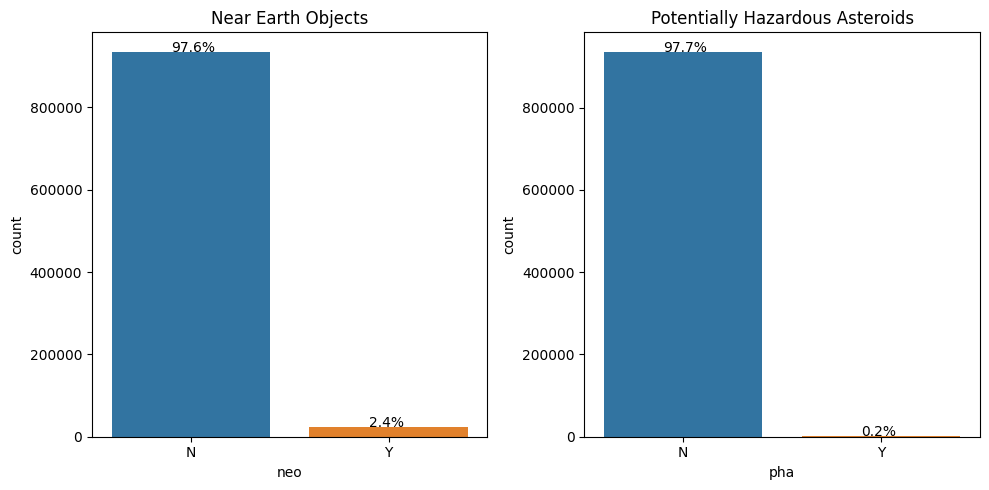

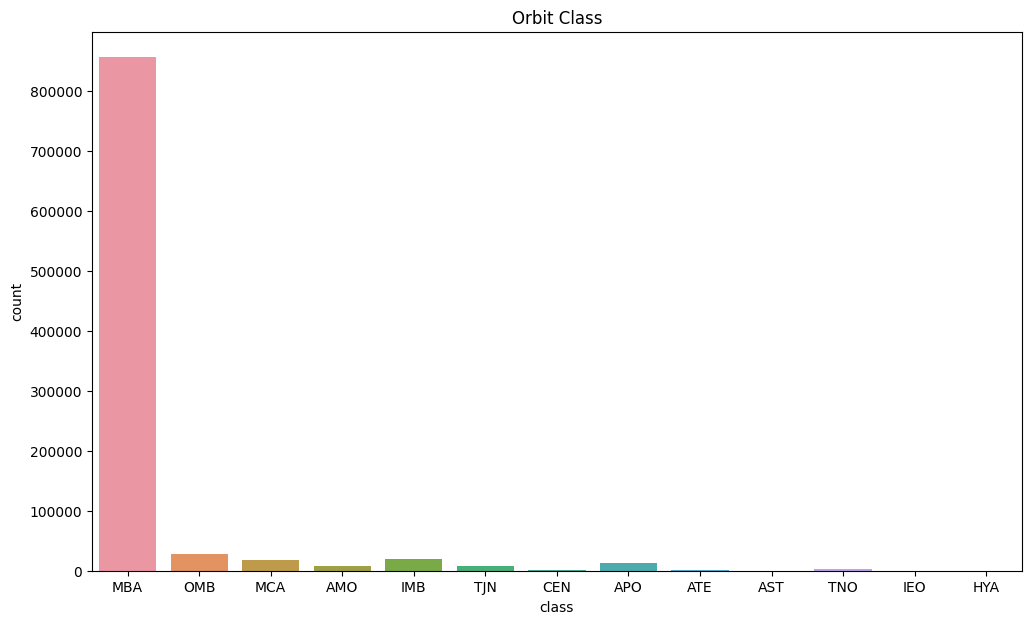

In [ ]:


# Figure with two subplots
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

#  Count plot of the "neo" variable on the left subplot
sns.countplot(x='neo', data=df, ax=axs[0])
axs[0].set_title('Near Earth Objects')

# Add percentage labels to the left subplot
total = float(len(df.neo))
for p in axs[0].patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_y() + p.get_height() + 3
    axs[0].annotate(percentage, (x, y))

#  Count plot of the "pha" variable on the right subplot
sns.countplot(x='pha', data=df, ax=axs[1])
axs[1].set_title('Potentially Hazardous Asteroids')

# Add percentage labels to the right subplot
total = float(len(df.pha))
for p in axs[1].patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_y() + p.get_height() + 3
    axs[1].annotate(percentage, (x, y))

# Adjust the spacing between the subplots
fig.tight_layout()

# Show the plot
plt.show()

# Count plot for Orbit Class
fig, ax = plt.subplots(figsize=(12, 7))
sns.countplot(x='class', data=df, ax=ax)
plt.title('Orbit Class')


plt.show()


- The dataset is highly unbalanced, 2.4% are **Near Earth Objects** and out of those only **0.2%** are Hazaerdous Asteriods

-  Out of 12 Orbit classes most of the orbit class is  of  **MBA** , which is around **89%.**

## Data Preprocessing

In [10]:
from sklearn.calibration import LabelEncoder

# Remove identifying columns
data=no_null_data.drop(['id', 'spkid', 'full_name', 'orbit_id', 'equinox'], axis=1).reset_index(drop=True)

# Encode categorical features and target
one_hot_encoded_data = pd.get_dummies(data, columns=['neo', 'class'])
one_hot_encoded_data['pha'] = LabelEncoder(
).fit_transform(one_hot_encoded_data['pha'])


In [11]:
from sklearn.model_selection import train_test_split

# Split train, validation, and test sets
x = one_hot_encoded_data.drop('pha', axis=1)
y = one_hot_encoded_data['pha'].to_frame()
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.4, random_state=100, stratify=y)
x_val, x_test, y_val, y_test = train_test_split(
    x_test, y_test, test_size=0.5, random_state=100, stratify=y_test)
print("Shape of original dataset :", one_hot_encoded_data.shape)
print("Shape of x_train set", x_train.shape)
print("Shape of y_train set", y_train.shape)
print("Shape of x_validation set", x_val.shape)
print("Shape of y_validation set", y_val.shape)
print("Shape of x_test set", x_test.shape)
print("Shape of y_test set", y_test.shape)


Shape of original dataset : (932335, 46)
Shape of x_train set (559401, 45)
Shape of y_train set (559401, 1)
Shape of x_validation set (186467, 45)
Shape of y_validation set (186467, 1)
Shape of x_test set (186467, 45)
Shape of y_test set (186467, 1)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Normalizing the features
# Normalizing after splitting could prevent leaking information about the validation set into the train set
# StandardScaler() is useful in classification and Normalizer() is useful in regression
x_train = StandardScaler().fit_transform(x_train)
x_val = StandardScaler().fit_transform(x_val)
x_test = StandardScaler().fit_transform(x_test)

In [ ]:
# Imbalance in target variable
y_train.value_counts()


pha
0      558161
1        1240
dtype: int64

### Fixed the Imbalancing of the dataset with SMOTE and RandomUnderSampler

In [12]:
from imblearn.over_sampling import SMOTE

# Data Upsampling - SMOTE
x_train_us, y_train_us = SMOTE(
    sampling_strategy=0.5, random_state=100).fit_resample(x_train, y_train)
y_train_us.value_counts()


pha
0      558161
1      279080
dtype: int64

In [13]:
from imblearn.under_sampling import RandomUnderSampler

# Data Undersampling - Random Undersampling
random_under_sampling = RandomUnderSampler(random_state=100)
x_train_us_rus, y_train_us_rus = random_under_sampling.fit_resample(x_train_us, y_train_us)

y_train_us_rus.value_counts()


pha
0      279080
1      279080
dtype: int64

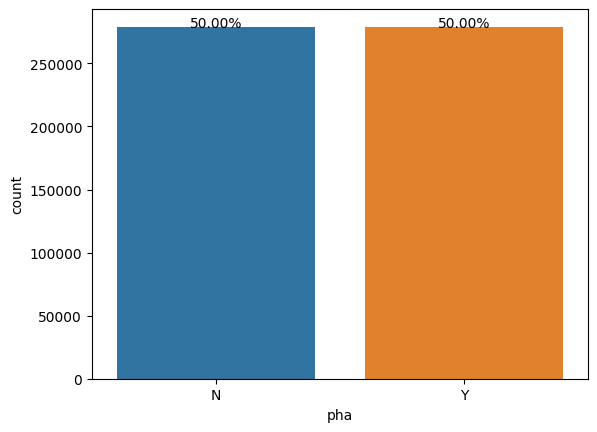

In [14]:
from imblearn.over_sampling import SMOTE

# Data Upsampling - SMOTE
x_train_SMOTE, y_train_SMOTE = SMOTE(
    sampling_strategy=0.5, random_state=100).fit_resample(x_train, y_train)
y_train_SMOTE.value_counts()

# Data Undersampling - Random Undersampling
random_under_SAMPLING = RandomUnderSampler(random_state=100)
x_train_us_UNDER, y_train_us_UNDER = random_under_SAMPLING.fit_resample(x_train_SMOTE, y_train_SMOTE)


y_train_us_UNDER['pha'] = y_train_us_UNDER['pha'].map({0: 'N', 1: 'Y'})

ax = sns.countplot(x="pha", data=y_train_us_UNDER)
total = float(len(y_train_us_UNDER))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 3, '{:.2f}%'.format(100*height/total), ha="center")
plt.show()

# Implementing Machine Learning Models


## RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report


rfc = RandomForestClassifier(class_weight='balanced', random_state=100)
# Skip Hyperparameter Tuning part because parameter with dafult value get the highest accuracy of model

rfc.fit(x_train_us_rus, y_train_us_rus)

# Predict for validation set
y_val_pred = rfc.predict(x_val)

# Metrics
precision_rfc, recall_rfc, fscore_rfc, support_rfc = precision_recall_fscore_support(
    y_val, y_val_pred, average='macro')
print(classification_report(y_val, y_val_pred))




              precision    recall  f1-score   support

           0       1.00      1.00      1.00    186054
           1       0.98      0.43      0.60       413

    accuracy                           1.00    186467
   macro avg       0.99      0.71      0.80    186467
weighted avg       1.00      1.00      1.00    186467



## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_fscore_support

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
lr = LogisticRegression()

lr.fit(x_train_us_rus, y_train_us_rus)
# Predict for validation set
y_val_pred = lr.predict(x_val)

# Metrics
precision_lr, recall_lr, fscore_lr, support_lr = precision_recall_fscore_support(
    y_val, y_val_pred, average='macro')
print(classification_report(y_val, y_val_pred))


              precision    recall  f1-score   support

           0       1.00      0.99      1.00    186054
           1       0.25      1.00      0.40       413

    accuracy                           0.99    186467
   macro avg       0.62      1.00      0.70    186467
weighted avg       1.00      0.99      1.00    186467



# Decision Tree

In [ ]:


dtc=DecisionTreeClassifier(class_weight='balanced', random_state=100)

dtc.fit(x_train_us_rus, y_train_us_rus)
# Predict for validation set
y_val_pred=dtc.predict(x_val)

# Metrics
precision_dtc, recall_dtc, fscore_dtc, support_dtc = precision_recall_fscore_support(y_val, y_val_pred, average='macro')
print(classification_report(y_val, y_val_pred))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00    186054
           1       0.94      0.43      0.59       413

    accuracy                           1.00    186467
   macro avg       0.97      0.72      0.80    186467
weighted avg       1.00      1.00      1.00    186467



# Naive Bayes Classifier

In [ ]:


gnb=GaussianNB()

gnb.fit(x_train_us_rus, y_train_us_rus)
# Predict for validation set
y_val_pred=gnb.predict(x_val)

# Metrics
precision_gnb, recall_gnb, fscore_gnb, support_gnb=precision_recall_fscore_support(y_val, y_val_pred, average='macro')
print (classification_report(y_val, y_val_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    186054
           1       0.00      0.00      0.00       413

    accuracy                           1.00    186467
   macro avg       0.50      0.50      0.50    186467
weighted avg       1.00      1.00      1.00    186467



# XG Boost


In [ ]:
from xgboost import XGBClassifier


xgbc = XGBClassifier(max_depth=10, learning_rate=0.1,
                     n_estimators=1000, eval_metric='mlogloss', random_state=100)

# Train the model on the training set
xgbc.fit(x_train, y_train)

# Make predictions on the testing set
y_pred = xgbc.predict(x_test)

# Calculate precision, recall, and f1 score
precision_xgbc = precision_score(y_test, y_pred)
recall_xgbc = recall_score(y_test, y_pred)
fscore_xgbc = f1_score(y_test, y_pred)

# Print precision, recall, and f1 score
print(f"Precision: {precision_xgbc:.2f}")
print(f"Recall: {recall_xgbc:.2f}")
print(f"F1 score: {fscore_xgbc:.2f}")

# Print classification report
print(classification_report(y_test, y_pred))


Precision: 0.97
Recall: 0.14
F1 score: 0.25
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    186054
           1       0.97      0.14      0.25       413

    accuracy                           1.00    186467
   macro avg       0.98      0.57      0.62    186467
weighted avg       1.00      1.00      1.00    186467



# KNN

In [ ]:
knc=KNeighborsClassifier(n_neighbors=1)
knc.fit(x_train_us_rus, y_train_us_rus)
# Predict for test set
y_test_pred=knc.predict(x_test)

# Metrics
precision_knc, recall_knc, fscore_knc, support_knc=precision_recall_fscore_support(y_test, y_test_pred, average='macro')
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    186054
           1       0.31      0.69      0.43       413

    accuracy                           1.00    186467
   macro avg       0.65      0.84      0.71    186467
weighted avg       1.00      1.00      1.00    186467



# Neural Network

## Multilayer Perceptron Model (MLP Model)

In [ ]:
# Model Structure
dl_model=Sequential()
dl_model.add(Dense(10, activation='relu', input_shape=(45,)))
dl_model.add(BatchNormalization())
dl_model.add(Dense(200, activation='relu'))
dl_model.add(BatchNormalization())
dl_model.add(Dropout(0.05))
dl_model.add(Dense(200, activation='relu'))
dl_model.add(BatchNormalization())
dl_model.add(Dense(1, activation='sigmoid'))

In [ ]:
dl_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                460       
                                                                 
 batch_normalization (BatchN  (None, 10)               40        
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 200)               2200      
                                                                 
 batch_normalization_1 (Batc  (None, 200)              800       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 200)               4

In [ ]:
# Compile the model
dl_model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:

# Set callback
model_checkpoint_cb=ModelCheckpoint(filepath='MLP_model.h5',
                                    save_best_only=True,
                                    save_weights_only=True)
early_stopping_cb=EarlyStopping(monitor='val_loss', 
                                mode='min',
                                verbose=1, 
                                patience=15, 
                                restore_best_weights=True)
reducelr_on_plateau_cb=ReduceLROnPlateau(factor=0.05, patience=3)

In [ ]:
dl_model_history=dl_model.fit(x_train_us_rus,y_train_us_rus, 
                              epochs=100, 
                              batch_size=110, 
                              validation_data=(x_val,y_val),
                              callbacks=[model_checkpoint_cb, early_stopping_cb, reducelr_on_plateau_cb])

Epoch 1/100
5075/5075 [==============================] - 22s 4ms/step - loss: 0.0233 - accuracy: 0.9949 - val_loss: 0.0377 - val_accuracy: 0.9911 - lr: 0.0010
Epoch 2/100
5075/5075 [==============================] - 21s 4ms/step - loss: 0.0168 - accuracy: 0.9966 - val_loss: 0.0202 - val_accuracy: 0.9951 - lr: 0.0010
Epoch 3/100
5075/5075 [==============================] - 20s 4ms/step - loss: 0.0151 - accuracy: 0.9971 - val_loss: 0.0257 - val_accuracy: 0.9941 - lr: 0.0010
Epoch 4/100
5075/5075 [==============================] - 20s 4ms/step - loss: 0.0144 - accuracy: 0.9973 - val_loss: 0.0238 - val_accuracy: 0.9947 - lr: 0.0010
Epoch 5/100
5075/5075 [==============================] - 21s 4ms/step - loss: 0.0136 - accuracy: 0.9974 - val_loss: 0.0186 - val_accuracy: 0.9959 - lr: 0.0010
Epoch 6/100
5075/5075 [==============================] - 20s 4ms/step - loss: 0.0127 - accuracy: 0.9975 - val_loss: 0.0097 - val_accuracy: 0.9969 - lr: 0.0010
Epoch 7/100
5075/5075 [=======================

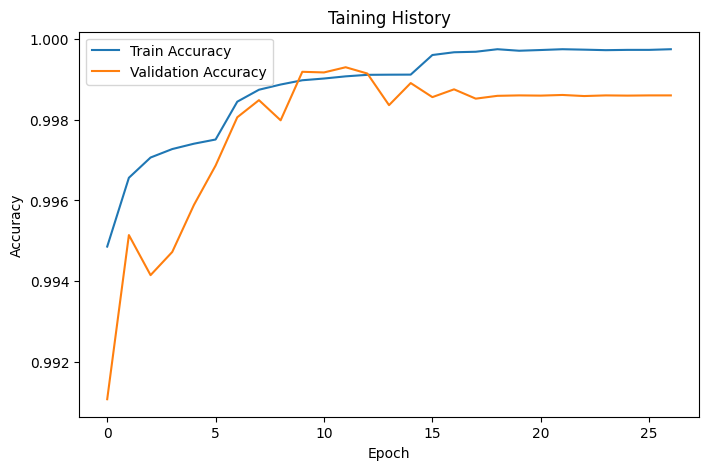

In [ ]:
# Evaluate traning history 
plt.figure(figsize=(8,5))
plt.plot(dl_model_history.history['accuracy'])
plt.plot(dl_model_history.history['val_accuracy'])
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Taining History')
plt.savefig('MLP_model_training_history.png')

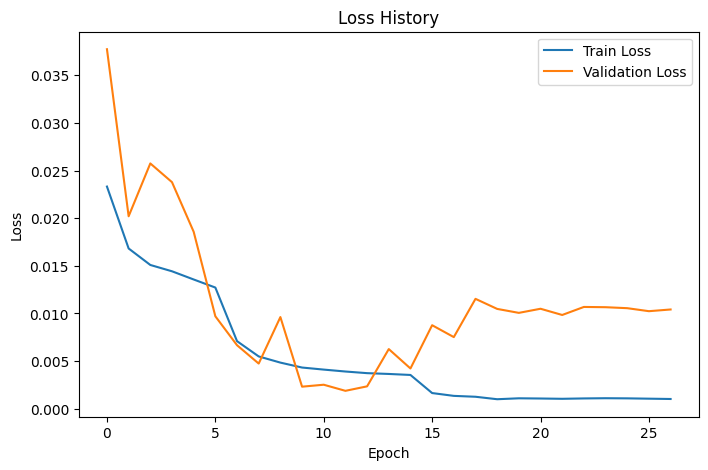

In [ ]:
# Evaluate loss history
plt.figure(figsize=(8,5))
plt.plot(dl_model_history.history['loss'])
plt.plot(dl_model_history.history['val_loss'])
plt.legend(['Train Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History')
plt.savefig('MLP_model_loss_history.png')

In [ ]:
# Predict for validation set
y_val_pred = dl_model.predict(x_val)
precision_dl, recall_dl, fscore_dl, support_dl=precision_recall_fscore_support(y_val, y_val_pred.round(), average='macro')
print(classification_report(y_val,y_val_pred.round()))


5828/5828 [==============================] - 6s 1ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    186054
           1       0.84      0.85      0.84       413

    accuracy                           1.00    186467
   macro avg       0.92      0.92      0.92    186467
weighted avg       1.00      1.00      1.00    186467



In [ ]:
# Load the best model and predict for validation set
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/data/

dl_model.load_weights(filepath="MLP_model.h5")
y_val_pred = dl_model.predict(x_val)
precision_dl, recall_dl, fscore_dl, support_dl=precision_recall_fscore_support(y_val, y_val_pred.round(), average='macro')
print(classification_report(y_val, y_val_pred.round()))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/data
5828/5828 [==============================] - 7s 1ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    186054
           1       0.84      0.85      0.84       413

    accuracy                           1.00    186467
   macro avg       0.92      0.92      0.92    186467
weighted avg       1.00      1.00      1.00    186467



# Model Comparision

In [ ]:

# Model Comparsion
Model_Selection=pd.DataFrame({'Model':['Random Forest', 'XGBoost', 'Decision Tree', 'Navie Bayes', 'Logistic Regression', 'K-Nearest Neighbors', 'MLP Model'],
                              'Precision':[precision_rfc, precision_xgbc, precision_dtc, precision_gnb, precision_lr,  precision_knc, precision_dl],
                              'Recall':[recall_rfc, recall_xgbc, recall_dtc, recall_gnb, recall_lr,  recall_knc, recall_dl],
                              'F1 Score':[fscore_rfc, fscore_xgbc, fscore_dtc, fscore_gnb, fscore_lr,  fscore_knc, fscore_dl],
                              })
Model_Selection.index+=1
Model_Selection

,Model,Precision,Recall,F1 Score
1,Random Forest,0.988317,0.714275,0.797658
2,XGBoost,0.967213,0.142857,0.248945
3,Decision Tree,0.970269,0.715467,0.795351
4,Navie Bayes,0.498893,0.499997,0.499444
5,Logistic Regression,0.623505,0.996617,0.696384
6,K-Nearest Neighbors,0.654000,0.842116,0.712024
7,MLP Model,0.918491,0.923546,0.921003
